# 1. Install Necessary Libraries

In [31]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

# 2. Import necessary dependencies and set environment variables

In [32]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")



In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

# Agentic System

An Agentic System, in the context of AI, refers to a system where one or more Agents are involved. These agents are not just passive entities that respond to commands but exhibit characteristics like:

Autonomy: They can act independently and make decisions.

Proactiveness: They can initiate actions and pursue goals.

Adaptability: They can learn and adapt to changes in their environment.

Goal-Oriented Behavior: They strive to achieve specific objectives or fulfill a particular purpose.

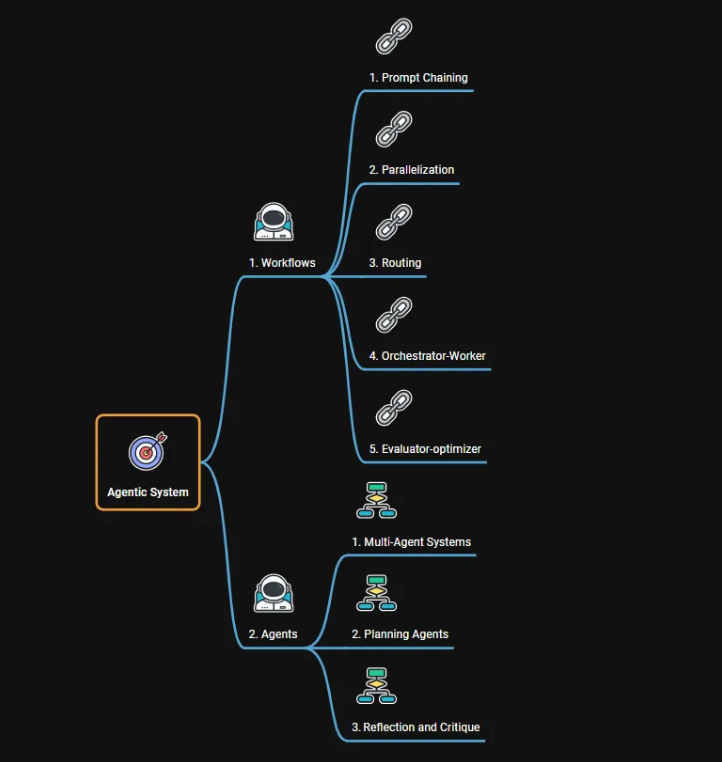

Detailed Blog : https://aiproductplaybook.substack.com/p/101-what-the-heck-are-agentic-system

# 3. Agents - Planning Agents (Plan and Execute)

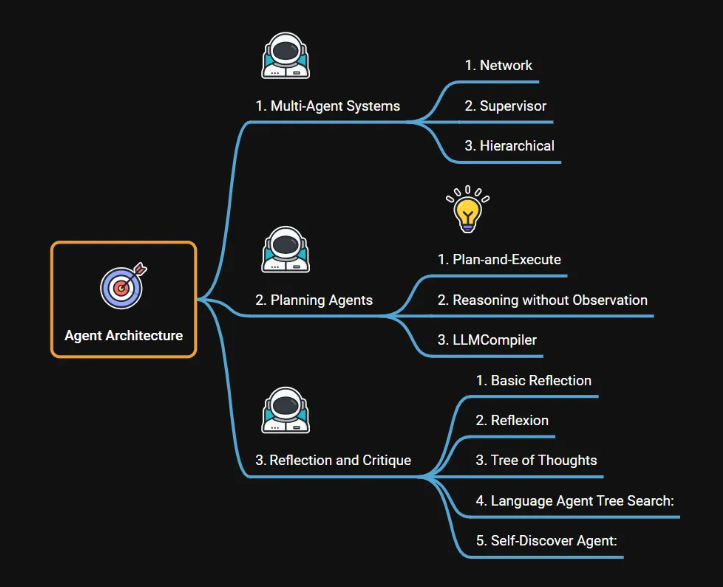

Detailed Blog : https://aiproductplaybook.substack.com/p/1010-what-the-heck-are-plan-and-execute

### a. Create Plan and Execute Agents

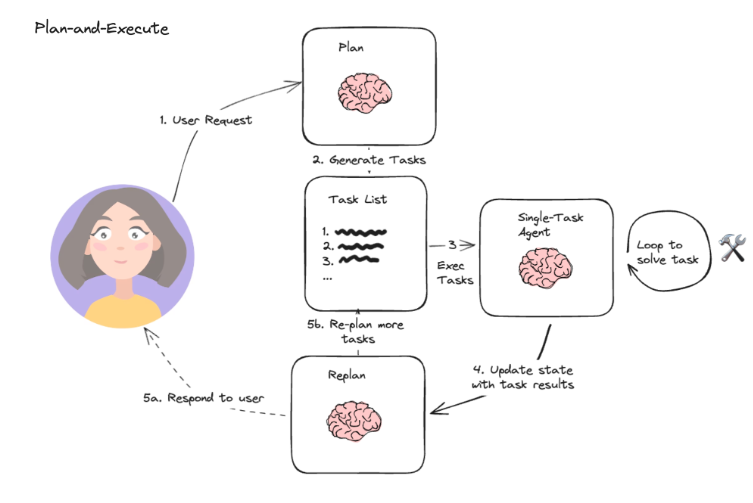

### b. Define the Tools

In [33]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

### c. Define our Execution Agent

In [34]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-mini")
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [35]:
agent_executor.invoke({"messages": [("user", "who is the winnner of the Euro Cup")]})

{'messages': [HumanMessage(content='who is the winnner of the Euro Cup', additional_kwargs={}, response_metadata={}, id='46e88f7f-87cd-4c65-81b3-5af03be29af9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dYZCBhUQZFEejD14MoHj6oF7', 'function': {'arguments': '{"query":"Euro Cup winner 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 95, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5f267486-39ab-45ff-8990-4d748ed81736-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Euro Cup winner 2023'}, 'id': 'call_dYZCBhUQ

### d. Define the State

The PlanExecute TypedDict provides a structured way to manage the state of a plan-following agent. It keeps track of the original input, the plan, the steps that have already been executed (along with their results), and the final response. The use of Annotated with operator.add ensures that the history of executed steps is preserved as the agent progresses through its plan. This is essential for agents that need to remember their past actions and use that information to inform future steps.

In [36]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

### e. Define the Planning step

1. Plan model

a. This code defines a Plan class using Pydantic's BaseModel. Pydantic is a library for data validation and parsing.

b. steps: List[str] declares a field named steps in the Plan class. This field is a list of strings. Each string in the list represents a step in the plan.

c. Field(description="...") adds a description to the steps field, which is good practice for documentation and can be used by tools that work with schemas. The description emphasizes that the steps should be in the correct order.

2. planner_prompt

a. This code creates a ChatPromptTemplate. This template defines the prompt that will be sent to the language model to generate the plan.

b. The prompt consists of two messages:

system message: This message provides instructions to the LLM. It tells the LLM to create a simple, step-by-step plan for a given objective. It emphasizes that each step should be self-contained and necessary, and that the final step should produce the final answer.

placeholder message: This uses a placeholder ({messages}) where the actual user input or objective will be inserted later.

3. planner

a. This code creates the planner object. It combines the prompt with the LLM and output parsing.

b. planner_prompt | ChatOpenAI(...): This uses the pipe operator (|) to chain the prompt template with a language model. It means the prompt will be formatted and then sent to the LLM.

c. ChatOpenAI(model="gpt-4o-mini", temperature=0): Specifies the LLM to use (gpt-4o-mini) and sets the temperature to 0. A temperature of 0 means the LLM will produce the most deterministic and predictable output (no randomness).

d. .with_structured_output(Plan): This is the crucial part. It tells the LLM to format its output as a Plan object (i.e., a JSON object that matches the Plan class structure). This ensures that the LLM's response can be easily parsed and used by the rest of the application.

Summary

This code defines a system for generating and using a plan.  It first defines the structure of a plan using Pydantic. Then, it creates a prompt that instructs the LLM to create such a plan. Finally, it combines the prompt with an LLM and structured output parsing to create a planner object.  This planner object can be called with an objective (the {messages} placeholder) and will return a Plan object containing the generated steps. This plan can then be used to guide the execution of subsequent actions.

In [37]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Plan)

In [38]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Wimbledon open winner?")
        ]
    }
)

Plan(steps=['Identify the current Wimbledon Open winner by checking the latest tournament results.', 'Find the name of the winner from the results.', 'Look up the hometown of the winner using a reliable source such as a sports news website or the official Wimbledon website.'])

### f. Define the Replan step

1. Response model

a. Defines a Pydantic model Response with a single field response of type str. This model represents a direct response to the user.

2. Act model

a. Defines a Pydantic model Act with a single field action.

b. action: Union[Response, Plan] is the key part. It uses Union to specify that the action field can be either a Response object or a Plan object. This allows the language model to choose between responding directly to the user or creating/updating a plan.

c. Field(description="...") provides a description that clarifies the choice between Response and Plan.

3. replanner_prompt

a. Creates a ChatPromptTemplate for replanning. This prompt is more sophisticated than the initial planning prompt.

b. It takes {input}, {plan}, and {past_steps} as input variables.

c. The prompt instructs the LLM to:

Re-evaluate the plan based on the original objective, the current plan, and the steps that have already been completed.

If the task is finished, respond directly to the user.

Otherwise, update the plan, adding only the necessary new steps. It's crucial that it doesn't repeat already completed steps.

4. replanner

a. Creates the replanner object.

b. replanner_prompt | ChatOpenAI(...): Combines the replanner_prompt with the ChatOpenAI model.

c. .with_structured_output(Act): Tells the LLM to format its output as an Act object. This means the LLM's response will be parsed into either a Response or a Plan object, depending on whether the LLM decides to respond directly to the user or update the plan.

Summary

This code defines a mechanism for a planning agent to dynamically adjust its plan as it executes steps. The Act model allows the agent to choose between responding directly to the user (using Response) or updating its plan (using Plan). The replanner_prompt guides the LLM in making this decision and in updating the plan appropriately, ensuring that only necessary new steps are added.  The replanner object combines the prompt, LLM, and structured output parsing to make this process executable.  This allows for more flexible and adaptive planning.

In [39]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Act)


### g. Define the helper functions

1. execute_step(state: PlanExecute)

a. This function executes a single step from the plan.

b. It takes the current state (of type PlanExecute, defined in previous code) as input.

c. It formats the current plan into a numbered list of steps (plan_str).

d. It extracts the first step (task) from the plan.

e. It constructs a prompt (task_formatted) that includes the entire plan and specifically highlights the task to be executed.

f. It uses await agent_executor.ainvoke(...) to asynchronously call an agent executor (agent_executor is assumed to be defined elsewhere) with the formatted task. This is where the actual agent execution happens.

g. It returns a dictionary containing the past_steps. The current task and the agent's response are added as a tuple to the past_steps list.

2. plan_step(state: PlanExecute)

a. This function creates the initial plan.

b. It takes the current state as input.

c. It uses await planner.ainvoke(...) to asynchronously call a planner (planner is assumed to be defined elsewhere) with the initial user input (state["input"]).

d. It returns a dictionary containing the generated plan (a list of steps).

3. replan_step(state: PlanExecute)

a. This function handles replanning.

b. It takes the current state as input.

c. It uses await replanner.ainvoke(state) to asynchronously call a replanner (replanner is assumed to be defined elsewhere) with the current state.

d. The replanner's output (output) can be either a Response object (if the task is complete) or a Plan object (if replanning is needed).

e. It checks the type of output.action:

If it's a Response, it returns a dictionary containing the final response.
If it's a Plan, it returns a dictionary containing the updated plan.

4. should_end(state: PlanExecute)

a. This function determines whether the workflow should end.

b. It checks if the state contains a response key and if that response is not empty.

c. If a response is present, it returns END, signaling the end of the workflow.

d. Otherwise, it returns "agent", indicating that the next step should be executed (the agent step).

Summary

These functions define the core execution loop for a planning agent. plan_step creates the initial plan, execute_step executes individual steps from the plan using an agent, replan_step updates the plan as needed, and should_end checks if the task is complete.  The asynchronous nature of the code allows for concurrent execution of potentially long-running operations, such as agent calls and planning. This code snippet would typically be used within a larger LangChain workflow to manage the planning and execution process.

In [40]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

### h. Define and visualize the graph

In [41]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

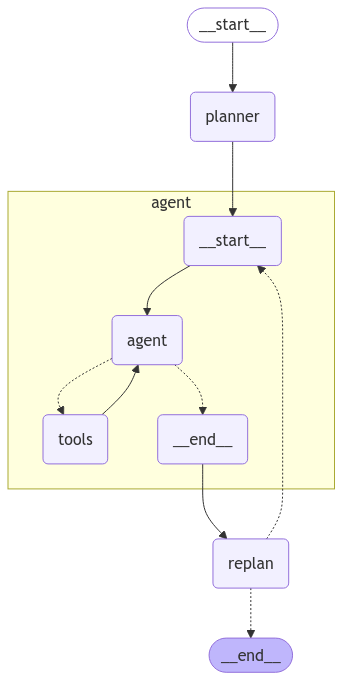

In [42]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

### i. Invoke the Agentic System

In [48]:
config = {"recursion_limit": 100}
inputs = {"input": "what is the hometown of the mens 2024 Wimbledon open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ["Identify the men's singles winner of the 2024 Wimbledon Open after the tournament concludes.", "Research the winner's biography to find their hometown."]}
{'past_steps': [("Identify the men's singles winner of the 2024 Wimbledon Open after the tournament concludes.", "The men's singles winner of the 2024 Wimbledon Open is Carlos Alcaraz, who defeated Novak Djokovic in the final. Alcaraz successfully retained his title, winning with scores of 6–2, 6–2, 7–6(7–4). \n\nIf you need the next step regarding his biography and hometown, please let me know!")]}
{'plan': ["Research Carlos Alcaraz's biography to find information about his hometown."]}
{'past_steps': [("Research Carlos Alcaraz's biography to find information about his hometown.", 'Carlos Alcaraz was born on May 5, 2003, in El Palmar, a locality in Murcia, Spain. El Palmar is noted for being his hometown, and it has become widely recognized in the context of his rising tennis career. \n\nIf you would like more detailed in

CancelledError: 

In [50]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the men's football world cup 2022 - Golden ball winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ["Identify the winner of the Golden Ball at the men's football World Cup 2022.", 'Research the background of the winner to find their hometown.']}
{'past_steps': [("Identify the winner of the Golden Ball at the men's football World Cup 2022.", "The winner of the Golden Ball at the men's football World Cup 2022 was Lionel Messi.")]}
{'plan': ['Research the background of Lionel Messi to find his hometown.']}
{'past_steps': [('Research the background of Lionel Messi to find his hometown.', 'Lionel Messi was born in Rosario, Argentina. This city is widely recognized as his hometown, and Messi is known for his strong ties to the area, including his support for local football clubs.')]}
{'plan': ["Confirm that Lionel Messi is the winner of the Golden Ball at the men's football World Cup 2022.", "State that Lionel Messi's hometown is Rosario, Argentina."]}
{'past_steps': [("Confirm that Lionel Messi is the winner of the Golden Ball at the men's football World Cup 2022.", "Lionel Mess

CancelledError: 